In [1]:
def df_clustering( n_clusters_, colors, df, plot = True):
    kmeans = KMeans(n_clusters=n_clusters_).fit(df[['win-rate', 'kill-death', 'headshot-kill']])
    labels = kmeans.labels_

    c_list = [colors[labels[i]] for i in range(df.shape[0])]

    center = kmeans.cluster_centers_

    x,y,z = df['win-rate'].values,df['kill-death'].values,df['headshot-kill'].values
    x_c, y_c, z_c = center[:, 0], center[:, 1], center[:, 2]

    if plot:
        plt.figure(figsize=(9, 6))
        ax1 = plt.subplot(111,projection='3d')
        
        ax1.scatter(x, y, z, s=15, color=c_list, alpha=0.5)
        ax1.scatter(x_c, y_c, z_c, s=120, alpha=0.8, c='black')
        ax1.set_title('Clustered silver players')
        ax1.set_xlabel('win-rate')
        ax1.set_ylabel('kill/death')
        ax1.set_zlabel('headshot/kill')
    
    return [labels, x_c,y_c,z_c]

In [2]:
colors = ['orange','green','cyan','red','blue','pink','gray','brown']


def plot_n_cluster(n_clusters, df):
    plt.figure(figsize=(20, 5))

    ax2 = plt.subplot(121,projection='3d')

    c = df
    x,y,z = c['win-rate'].values, c['kill-death'].values, c['headshot-kill'].values
    ax2.scatter(x, y, z, s=15, alpha=0.5)

    ax2.set_xlabel('win-rate')
    ax2.set_ylabel('kill/death')
    ax2.set_zlabel('headshot/kill')


    df_labeled, x_c, y_c, z_c = df_clustering(n_clusters, colors, df, plot = False)

    df['label'] = df_labeled


    ax1 = plt.subplot(122,projection='3d')

    for i in range(n_clusters):
        c = df[df.label == i]
        x,y,z = c['win-rate'].values, c['kill-death'].values, c['headshot-kill'].values
        ax1.scatter(x, y, z, s=15, color=colors[i], alpha=0.5, label='cluster:{}'.format(i))

    ax1.scatter(x_c, y_c, z_c, s=120, alpha=0.8, c='black')
    # ax1.set_title('{} clustered by k-means'.format(target_rank))
    ax1.set_xlabel('win-rate')
    ax1.set_ylabel('kill/death')
    ax1.set_zlabel('headshot/kill')
    plt.legend()

    plt.suptitle('{} clustering by k-means'.format(target_rank), fontsize = 20)

    plt.savefig('{} clustering by k-means'.format(target_rank))
    
    return df_labeled, x_c, y_c, z_c
    

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from numpy import inf
from scipy.stats import moment

target_rank = 'silver players'
df_raw = pd.read_csv('silver_player.csv', index_col=0)

# add ratio features
winRate = df_raw['total_wins']/df_raw['total_rounds_played']
winRate[winRate == inf] = 0
KD = df_raw['total_kills']/df_raw['total_deaths']
KD[KD == inf] = 0
HDK = df_raw['total_kills_headshot']/df_raw['total_kills']
HDK[HDK == inf] = 0

df = pd.DataFrame(np.stack([winRate, KD, HDK], axis = 1), index=df_raw.index, columns=['win-rate', 'kill-death', 'headshot-kill'])
df = pd.concat([df, df_raw],axis = 1)

In [4]:
df_clean = df[ (df['win-rate']<=1) & ( df['headshot-kill']<=1) & (df['total_shots_fired']>df['total_kills']) &\
              (df['total_time_played'] <= 1963*12*60*60) & \
             (df['total_kills']/9 <= df['total_rounds_played'])]
df_clean.shape, df.shape

((14367, 14), (14660, 14))

# K-means

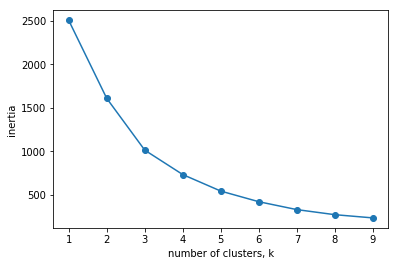

In [5]:
ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(df_clean[['win-rate', 'kill-death', 'headshot-kill']])  
    inertias.append(model.inertia_)  

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cluster size distribution of silver players
cluster:	size:	
0		55
1		3495
2		10817


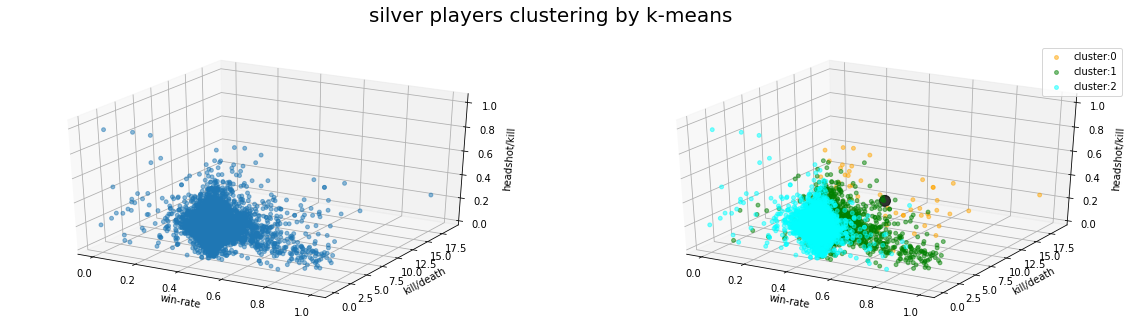

In [6]:
df_labeled, x_c, y_c, z_c = plot_n_cluster(3, df_clean)
# size of each cluster
print('cluster size distribution of {}'.format(target_rank))
count_label0 = list(df_labeled).count(0)
count_label1 = list(df_labeled).count(1)
count_label2 = list(df_labeled).count(2)

print('cluster:\tsize:\t')
print('{}\t\t{}'.format(0, count_label0))
print('{}\t\t{}'.format(1, count_label1))
print('{}\t\t{}'.format(2, count_label2))

[array([0, 0, 0, ..., 1, 1, 0], dtype=int32),
 array([ 0.47956485,  0.53828956,  0.65699349]),
 array([ 0.82904429,  1.31167509,  4.91421371]),
 array([ 0.30815082,  0.32936053,  0.46427057])]

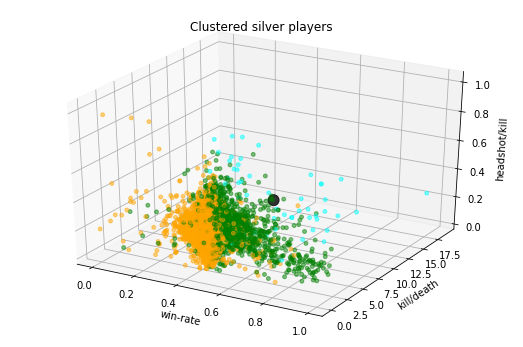

In [7]:
df_clustering(3, colors, df_clean, plot = True)

In [8]:
dict_kmeans = {}
dict_kmeans['label'] = df_labeled
dict_kmeans['x_c'] = x_c
dict_kmeans['y_c'] = y_c
dict_kmeans['z_c'] = z_c

In [9]:
import pickle

with open('silver_df_clean.pickle', 'wb') as handle:
    pickle.dump(df_clean, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('silver_kmean.pickle', 'wb') as handle:
    pickle.dump(dict_kmeans, handle, protocol=pickle.HIGHEST_PROTOCOL)
